# Important

**Check GPU**

In [118]:
!nvidia-smi

Mon Jan 31 22:07:59 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P0    30W /  70W |   9820MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Translate

Какой функционал можно добавить: проверить качество с пунктуацией и без, убрать вводные слова

In [2]:
!pip install transformers[sentencepiece]

     |████████████████████████████████| 3.5 MB 8.0 MB/s 
     |████████████████████████████████| 596 kB 49.2 MB/s 
     |████████████████████████████████| 895 kB 55.1 MB/s 
     |████████████████████████████████| 67 kB 1.6 MB/s 
     |████████████████████████████████| 6.8 MB 28.1 MB/s 
     |████████████████████████████████| 1.2 MB 48.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [3]:
from transformers import pipeline

model_checkpoint = "Helsinki-NLP/opus-mt-ru-en"
translator = pipeline("translation", model=model_checkpoint)
translator("Хочу пиццу")

Downloading:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/293M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/784k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

[{'translation_text': 'I want pizza.'}]

In [4]:
%%time

translator("Подожди ты забыл пирожок")

CPU times: user 617 ms, sys: 3.5 ms, total: 621 ms
Wall time: 629 ms


[{'translation_text': 'Wait, you forgot the cake.'}]

# Download Dataset

**Kaggle Dataset**

In [9]:
!pip install opendatasets

In [10]:
import opendatasets as od

Для следующей ячейки потребуются данные из Kaggle аккаунта:

You Profile -> Account -> Create New API Token

In [11]:
od.download("https://www.kaggle.com/jessicali9530/stl10")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: lightlegends
Your Kaggle Key: ··········


100%|██████████| 1.88G/1.88G [00:28<00:00, 71.4MB/s]


# Initialization Dataset

In [ ]:
!mkdir features

In [ ]:
from pathlib import Path
import torch
from PIL import Image, ImageFile
import math
import numpy as np
import pandas as pd
from glob import glob
from tqdm.notebook import tqdm
from IPython.display import Image as Img
from IPython.display import display

batch_size = 512

images_dir = "/content/stl10/train_images"
features_dir = "/content/features"

photos_path = Path(images_dir) 
features_path = Path(features_dir)

# List all picture in the folder
photos_files = list(photos_path.glob("*.png"))

# Print some statistics
print(f"Photos found: {len(photos_files)}")

Photos found: 5000


# CLIP

За основу взят репозиторий: https://github.com/haltakov/natural-language-image-search

In [8]:
!pip install git+https://github.com/openai/CLIP.git
#!pip install torch==1.7.1+cu101 torchvision==0.8.2+cu101 -f https://download.pytorch.org/whl/torch_stable.html

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-ztqg3_vd
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-ztqg3_vd
     |████████████████████████████████| 64 kB 2.6 MB/s 
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369221 sha256=c62656eda480ef6cd25b53f68475204685f71b8c079455f93d6ba2a4401c7704
  Stored in directory: /tmp/pip-ephem-wheel-cache-m503d9hr/wheels/fd/b9/c3/5b4470e35ed76e174bff77c92f91da82098d5e35fd5bc8cdac
  Created wheel for ftfy: filename=ftfy-6.0.3-py3-none-any.whl size=41933 sha256=6123c0bb00e13692a2998b50c3413c09d6c2d80581ce2b23028286bbd2cef7ac
  Stored in directory: /root/.cache/pip/wheels/19/f5/38/273eb3b5e76dfd850619312f693716ac4518b498f5ffb6f56d
Successfully built clip ftfy


In [9]:
import clip
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14']

In [19]:
# Load the open CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

In [25]:
# Function that computes the feature vectors for a batch of images
def compute_clip_features(photos_batch):
    # Load all the photos from the files
    photos = [Image.open(photo_file) for photo_file in photos_batch]
    
    # Preprocess all photos
    photos_preprocessed = torch.stack([preprocess(photo) for photo in photos]).to(device)

    with torch.no_grad():
        # Encode the photos batch to compute the feature vectors and normalize them
        photos_features = model.encode_image(photos_preprocessed)
        photos_features /= photos_features.norm(dim=-1, keepdim=True)

    # Transfer the feature vectors back to the CPU and convert to numpy
    return photos_features.cpu().numpy()

In [21]:
# Compute how many batches are needed
batches = math.ceil(len(photos_files) / batch_size)
print(f"All batches: {batches}")

# Process each batch
for i in tqdm(range(batches)):
    print(f"Processing batch {i+1}/{batches}")

    batch_ids_path = features_path / f"{i:010d}.csv"
    batch_features_path = features_path / f"{i:010d}.npy"
    
    # Only do the processing if the batch wasn't processed yet
    if not batch_features_path.exists():
        try:
            # Select the photos for the current batch
            batch_files = photos_files[i*batch_size : min(len(photos_files), (i+1)*batch_size)]

            # Compute the features and save to a numpy file
            batch_features = compute_clip_features(batch_files)
            np.save(batch_features_path, batch_features)

            # Save the photo IDs to a CSV file
            photo_ids = [photo_file.name.split(".")[0] for photo_file in batch_files]
            photo_ids_data = pd.DataFrame(photo_ids, columns=['photo_id'])
            photo_ids_data.to_csv(batch_ids_path, index=False)
        except:
            # Catch problems with the processing to make the process more robust
            print(f'Problem with batch {i}')

All batches: 10


  0%|          | 0/10 [00:00<?, ?it/s]

Processing batch 1/10
Processing batch 2/10
Processing batch 3/10
Processing batch 4/10
Processing batch 5/10
Processing batch 6/10
Processing batch 7/10
Processing batch 8/10
Processing batch 9/10
Processing batch 10/10


In [22]:
def add_photo_path(name):
  return f'{images_dir}/{name}.png'

# Load all numpy files
features_list = [np.load(features_file) for features_file in sorted(features_path.glob("*.npy"))]

# Concatenate the features and store in a merged file
features = np.concatenate(features_list)
np.save(features_path / "features.npy", features)

# Load all the photo IDs
photo_ids = pd.concat([pd.read_csv(ids_file) for ids_file in sorted(features_path.glob("*.csv"))])
photo_ids = photo_ids["photo_id"].apply(add_photo_path)
photo_ids.to_csv(features_path / "photo_ids.csv", index=False)

In [ ]:
import os
from glob import glob

for file in glob('/content/features/0*.*'):
    os.remove(file)

In [ ]:
def encode_search_query(search_query):
  with torch.no_grad():
    # Encode it to a feature vector using CLIP
    text_encoded = model.encode_text(clip.tokenize(search_query).to(device))
    text_encoded /= text_encoded.norm(dim=-1, keepdim=True)

  # Retrieve the description vector and the photo vectors
  return text_encoded.cpu().numpy()

def find_best(text_features, photo_features, photo_ids, counter=5):
  # Compute the similarity between the search query and each photo using the Cosine similarity
  similarities = (photo_features @ text_features.T).squeeze(1)

  # Sort the photos by their similarity score -> best_photo_idx = Sorted list of photo indexes
  best_photo_idx = np.argsort(similarities)[::-1]

  # Return the photo IDs of the best matches, cosine similarity and sorted list of photo indexes
  return [photo_ids[i] for i in best_photo_idx[:counter]], similarities, best_photo_idx


def text_search(search_query, photo_features, photo_ids, counter=5):
  # Encode the search query
  text_features = encode_search_query(search_query)

  # Find the best matches
  best_photo_name, similarities, best_photo_idx = find_best(text_features, photo_features, photo_ids, counter)

  for i in range(counter):
    print("Photo name: {} | Cosine similarity: {}".format(best_photo_name[i],similarities[best_photo_idx[i]]))
  
  # Display photos
  for photo in best_photo_name:
    display(Img(photo))

In [ ]:
# load the img idx
photo_ids = list(pd.read_csv(f"{features_dir}/photo_ids.csv")['photo_id'])

# load the features vectors
photo_features = np.load(f"{features_dir}/features.npy")

Small monkey
Photo name: /content/stl10/train_images/train_image_png_1814.png | Cosine similarity: 0.311767578125
Photo name: /content/stl10/train_images/train_image_png_3279.png | Cosine similarity: 0.30712890625
Photo name: /content/stl10/train_images/train_image_png_4511.png | Cosine similarity: 0.305908203125


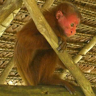

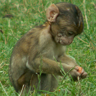

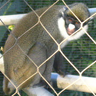

In [ ]:
#text = translator("Черная кошка сидит")[0]['translation_text']
text = "Small monkey"
print(text)
text_search(text, photo_features, photo_ids, 3)

Значение вектора для текста:

In [ ]:
text = "Small monkey"
encode_search_query(text)[0]

array([-2.1301e-02,  6.0654e-03, -3.5767e-02, -6.7940e-03, -1.0567e-02,
        2.0996e-02, -2.9526e-02, -1.1658e-01, -5.9082e-02,  7.3242e-03,
        2.2171e-02,  1.0841e-02, -2.0813e-02, -1.3954e-02,  3.9825e-02,
       -5.0201e-03,  2.1973e-02, -5.3711e-03,  5.6152e-03, -1.1627e-02,
        3.6743e-02,  5.5176e-02,  2.1393e-02,  2.1805e-02, -6.9427e-03,
        2.7634e-02, -5.4474e-03,  3.7659e-02, -2.9251e-02,  3.4576e-02,
        8.1711e-03, -3.9764e-02, -1.9875e-03,  4.2786e-02,  2.3270e-02,
       -2.0050e-02, -7.2517e-03,  3.3245e-03, -1.2314e-02,  1.0895e-02,
       -1.6083e-02,  2.3575e-02,  1.1925e-02,  1.7822e-02,  1.2497e-02,
        2.6428e-02, -1.9958e-02,  2.9202e-03, -6.0120e-03,  6.0272e-03,
        4.8859e-02, -1.4870e-02, -2.8351e-02, -3.1830e-02,  2.4643e-02,
        1.8723e-02,  2.9964e-03,  4.9225e-02,  1.1665e-02,  3.7567e-02,
        5.8014e-02, -5.4291e-02,  1.5083e-02, -1.0788e-02, -8.5449e-03,
       -3.3661e-02, -3.7170e-02,  5.6305e-02,  2.4307e-02, -8.46

Значение вектора для изображения:

In [ ]:
image_name = "train_image_png_1814.png"
compute_clip_features(["{}/{}".format(images_dir,image_name)])[0]

array([-9.7961e-03,  5.0354e-04,  2.7313e-02,  1.7805e-03,  6.0692e-03,
       -9.5825e-03,  4.1046e-02, -2.2339e-02,  4.3213e-02, -2.3636e-02,
        1.2016e-02,  3.2449e-04, -2.3479e-03, -2.7435e-02,  1.5038e-02,
       -1.7822e-04,  4.4525e-02, -1.5701e-02,  2.1820e-02,  3.3966e-02,
       -1.9302e-02,  1.8677e-02,  4.0161e-02, -1.2451e-02, -3.6285e-02,
        2.8442e-02,  5.0392e-03, -1.9409e-02, -3.9642e-02, -1.4520e-04,
        3.8879e-02, -3.5492e-02,  6.1157e-02,  3.9597e-03, -3.9551e-02,
       -6.0730e-02,  1.1925e-02,  1.6846e-02, -4.5563e-02,  1.1426e-01,
        9.9792e-03,  7.5817e-04, -1.4114e-02, -2.9587e-02, -5.6887e-04,
       -1.0429e-02, -8.7357e-03,  5.9723e-02,  1.8661e-02, -1.4603e-02,
        8.1444e-04, -1.8402e-02, -1.2047e-02, -6.5384e-03,  6.3324e-03,
       -7.0992e-03, -3.4424e-02,  6.9153e-02, -7.0000e-03, -1.0895e-02,
        1.1865e-01,  4.5662e-03, -2.7405e-02, -1.5717e-02, -2.6871e-02,
       -3.1174e-02, -4.9713e-02,  1.5503e-01, -3.9490e-02, -2.74

# RuCLIP

In [1]:
!pip install ruclip==0.0.1 > /dev/null

In [2]:
import os
import glob
import pandas as pd
import torch
import ruclip
import random
import numpy as np
import skimage
from glob import glob

import base64
import requests
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
import random

In [3]:
f"All models: {list(ruclip.MODELS.keys())}"

"All models: ['ruclip-vit-base-patch32-224', 'ruclip-vit-base-patch16-224', 'ruclip-vit-large-patch14-224', 'ruclip-vit-large-patch14-336', 'ruclip-vit-base-patch32-384', 'ruclip-vit-base-patch16-384']"

In [4]:
device = 'cuda'
model, preprocess = ruclip.load('ruclip-vit-base-patch32-384', device=device)

Downloading:   0%|          | 0.00/748k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/346 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/606M [00:00<?, ?B/s]

In [5]:
templates = ['{}', 'это {}']
predictor = ruclip.Predictor(model, preprocess, device, bs=8, templates=templates)

In [7]:
# Function that computes the feature vectors for a batch of images
def compute_ruclip_features(photos_batch):
    # Load all the photos from the files
    photos = [Image.open(photo_file) for photo_file in photos_batch]

    with torch.no_grad():
        # Encode the photos batch to compute the feature vectors and normalize them
        photos_features = predictor.get_image_latents(photos)

    # Transfer the feature vectors back to the CPU and convert to numpy
    return photos_features.cpu().numpy()

In [ ]:
# Compute how many batches are needed
batches = math.ceil(len(photos_files) / batch_size)
print(f"All batches: {batches}")

# Process each batch
for i in tqdm(range(batches)):
    print(f"Processing batch {i+1}/{batches}")

    batch_ids_path = features_path / f"{i:010d}.csv"
    batch_features_path = features_path / f"{i:010d}.npy"
    
    # Only do the processing if the batch wasn't processed yet
    if not batch_features_path.exists():
        try:
            # Select the photos for the current batch
            batch_files = photos_files[i*batch_size : min(len(photos_files), (i+1)*batch_size)]

            # Compute the features and save to a numpy file
            batch_features = compute_ruclip_features(batch_files)
            np.save(batch_features_path, batch_features)

            # Save the photo IDs to a CSV file
            photo_ids = [photo_file.name.split(".")[0] for photo_file in batch_files]
            photo_ids_data = pd.DataFrame(photo_ids, columns=['photo_id'])
            photo_ids_data.to_csv(batch_ids_path, index=False)
        except:
            # Catch problems with the processing to make the process more robust
            print(f'Problem with batch {i}')

In [18]:
def add_photo_path(name):
  return f'{images_dir}/{name}.png'

# Load all numpy files
features_list = [np.load(features_file) for features_file in sorted(features_path.glob("*.npy"))]

# Concatenate the features and store in a merged file
features = np.concatenate(features_list)
np.save(features_path / "features.npy", features)

# Load all the photo IDs
photo_ids = pd.concat([pd.read_csv(ids_file) for ids_file in sorted(features_path.glob("*.csv"))])
photo_ids = photo_ids["photo_id"].apply(add_photo_path)
photo_ids.to_csv(features_path / "photo_ids.csv", index=False)

In [28]:
import os
from glob import glob

for file in glob('/content/features/0*.*'):
    os.remove(file)

In [22]:
def encode_search_query(search_query):
  with torch.no_grad():
    # Encode it to a feature vector using RuCLIP
    text_encoded = predictor.get_text_latents([search_query])

  # Retrieve the description vector and the photo vectors
  return text_encoded.cpu().numpy()

def find_best(text_features, photo_features, photo_ids, counter=5):
  # Compute the similarity between the search query and each photo using the Cosine similarity
  similarities = (photo_features @ text_features.T).squeeze(1)

  # Sort the photos by their similarity score -> best_photo_idx = Sorted list of photo indexes
  best_photo_idx = np.argsort(similarities)[::-1]

  # Return the photo IDs of the best matches, cosine similarity and sorted list of photo indexes
  return [photo_ids[i] for i in best_photo_idx[:counter]], similarities, best_photo_idx


def text_search(search_query, photo_features, photo_ids, counter=5):
  # Encode the search query
  text_features = encode_search_query(search_query)

  # Find the best matches
  best_photo_name, similarities, best_photo_idx = find_best(text_features, photo_features, photo_ids, counter)

  for i in range(counter):
    print("Photo name: {} | Cosine similarity: {}".format(best_photo_name[i],similarities[best_photo_idx[i]]))
  
  # Display photos
  for photo in best_photo_name:
    display(Img(photo))

In [23]:
# load the img idx
photo_ids = list(pd.read_csv(f"{features_dir}/photo_ids.csv")['photo_id'])

# load the features vectors
photo_features = np.load(f"{features_dir}/features.npy")

Обезьяна играет с мячиком
Photo name: /content/stl10/train_images/train_image_png_1815.png | Cosine similarity: 0.5415058732032776
Photo name: /content/stl10/train_images/train_image_png_2566.png | Cosine similarity: 0.4310559034347534
Photo name: /content/stl10/train_images/train_image_png_2900.png | Cosine similarity: 0.41905447840690613


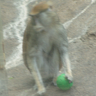

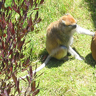

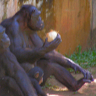

In [27]:
text = "Обезьяна играет с мячиком"
print(text)
text_search(text, photo_features, photo_ids, 3)

# RuCLIP-SB

Есть предположение, что будет хорошо работать на изображениях, у которых разрешение высоты и ширины больше или равны 224.

На изображениях 96x96 работает хуже всех.

In [29]:
%%capture
!pip install git+https://github.com/cene555/ruCLIP-SB.git
!pip install pymorphy2
!gdown -O ruCLIP-SB.pkl https://drive.google.com/uc?id=1-CghuC9TCIDyn5H3zQS6ho_TNiudzJCX
!gdown -O cifar100classes.json https://drive.google.com/uc?id=1ZJhOp5RP5wY31TyJgGNXa9xaJO8SdAhf

In [30]:
import torch
from torchvision import transforms
import transformers
from transformers import BertTokenizer
from ruclipsb import ruCLIPSB
from ruclipsb.utils import tokenize, _convert_image_to_rgb
from PIL import ImageCms
import cv2
try:
    from torchvision.transforms import InterpolationMode
    BICUBIC = InterpolationMode.BICUBIC
except ImportError:
    BICUBIC = Image.BICUBIC

In [90]:
import warnings
import torch.nn as nn

warnings.filterwarnings("ignore", category=UserWarning)

In [32]:
torch.manual_seed(1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [33]:
model = ruCLIPSB()
model.load_state_dict(torch.load('ruCLIP-SB.pkl', map_location=device))
model = model.half().to(device)

model = model.eval()
for x in model.parameters(): x.requires_grad = False
torch.cuda.empty_cache()

Downloading: "https://github.com/SwinTransformer/storage/releases/download/v1.0.0/swin_tiny_patch4_window7_224.pth" to /root/.cache/torch/hub/checkpoints/swin_tiny_patch4_window7_224.pth


Downloading:   0%|          | 0.00/632 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/45.5M [00:00<?, ?B/s]

Some weights of the model checkpoint at cointegrated/rubert-tiny were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [34]:
tokenizer = BertTokenizer.from_pretrained("cointegrated/rubert-tiny")

Downloading:   0%|          | 0.00/235k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/341 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/457k [00:00<?, ?B/s]

In [35]:
transform = transforms.Compose([
            transforms.Resize(224),
            transforms.CenterCrop(224),
            _convert_image_to_rgb,
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),])

In [110]:
# Function that computes the feature vectors for a batch of images
def compute_ruclipsb_features(photos_batch):
    # Load all the photos from the files
    photos = []
    for i in photos_batch:
      image = cv2.imread(str(i))
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      image = Image.fromarray(image)
      photos.append(transform(image))

    # Preprocess all photos
    photos_preprocessed = torch.stack(photos, axis=0).to(device)

    with torch.no_grad():
        # Encode the photos batch to compute the feature vectors and normalize them
        photos_features = model.encode_image(photos_preprocessed)
        photos_features /= photos_features.norm(dim=-1, keepdim=True)

    # Transfer the feature vectors back to the CPU and convert to numpy
    return photos_features.cpu().numpy()

In [111]:
# Compute how many batches are needed
batches = math.ceil(len(photos_files) / batch_size)
print(f"All batches: {batches}")

# Process each batch
for i in tqdm(range(batches)):
    print(f"Processing batch {i+1}/{batches}")

    batch_ids_path = features_path / f"{i:010d}.csv"
    batch_features_path = features_path / f"{i:010d}.npy"
    
    # Only do the processing if the batch wasn't processed yet
    if not batch_features_path.exists():
        try:
            # Select the photos for the current batch
            batch_files = photos_files[i*batch_size : min(len(photos_files), (i+1)*batch_size)]

            # Compute the features and save to a numpy file
            batch_features = compute_ruclipsb_features(batch_files)
            np.save(batch_features_path, batch_features)

            # Save the photo IDs to a CSV file
            photo_ids = [photo_file.name.split(".")[0] for photo_file in batch_files]
            photo_ids_data = pd.DataFrame(photo_ids, columns=['photo_id'])
            photo_ids_data.to_csv(batch_ids_path, index=False)
        except:
            # Catch problems with the processing to make the process more robust
            print(f'Problem with batch {i}')

All batches: 10


  0%|          | 0/10 [00:00<?, ?it/s]

Processing batch 1/10
Processing batch 2/10
Processing batch 3/10
Processing batch 4/10
Processing batch 5/10
Processing batch 6/10
Processing batch 7/10
Processing batch 8/10
Processing batch 9/10
Processing batch 10/10


In [112]:
def add_photo_path(name):
  return f'{images_dir}/{name}.png'

# Load all numpy files
features_list = [np.load(features_file) for features_file in sorted(features_path.glob("*.npy"))]

# Concatenate the features and store in a merged file
features = np.concatenate(features_list)
np.save(features_path / "features.npy", features)

# Load all the photo IDs
photo_ids = pd.concat([pd.read_csv(ids_file) for ids_file in sorted(features_path.glob("*.csv"))])
photo_ids = photo_ids["photo_id"].apply(add_photo_path)
photo_ids.to_csv(features_path / "photo_ids.csv", index=False)

In [113]:
import os
from glob import glob

for file in glob('/content/features/0*.*'):
    os.remove(file)

In [114]:
def encode_search_query(search_query):
  with torch.no_grad():
    # Encode it to a feature vector using CLIP
    text_encoded, attention_mask = tokenize(tokenizer, [search_query], 77)
    text_encoded, attention_mask = text_encoded.to(device), attention_mask.to(device)
    text_encoded = model.encode_text(text_encoded, attention_mask)
    text_encoded /= text_encoded.norm(dim=-1, keepdim=True)

  # Retrieve the description vector and the photo vectors
  return text_encoded.cpu().numpy()

def find_best(text_features, photo_features, photo_ids, counter=5):
  # Compute the similarity between the search query and each photo using the Cosine similarity
  similarities = (photo_features @ text_features.T).squeeze(1)

  # Sort the photos by their similarity score -> best_photo_idx = Sorted list of photo indexes
  best_photo_idx = np.argsort(similarities)[::-1]

  # Return the photo IDs of the best matches, cosine similarity and sorted list of photo indexes
  return [photo_ids[i] for i in best_photo_idx[:counter]], similarities, best_photo_idx


def text_search(search_query, photo_features, photo_ids, counter=5):
  # Encode the search query
  text_features = encode_search_query(search_query)

  # Find the best matches
  best_photo_name, similarities, best_photo_idx = find_best(text_features, photo_features, photo_ids, counter)

  for i in range(counter):
    print("Photo name: {} | Cosine similarity: {}".format(best_photo_name[i],similarities[best_photo_idx[i]]))
  
  # Display photos
  for photo in best_photo_name:
    display(Img(photo))

In [115]:
# load the img idx
photo_ids = list(pd.read_csv(f"{features_dir}/photo_ids.csv")['photo_id'])

# load the features vectors
photo_features = np.load(f"{features_dir}/features.npy")

Обезьяна играет с мячиком
Photo name: /content/stl10/train_images/train_image_png_1018.png | Cosine similarity: 0.181772843003273
Photo name: /content/stl10/train_images/train_image_png_2987.png | Cosine similarity: 0.18176931142807007
Photo name: /content/stl10/train_images/train_image_png_2387.png | Cosine similarity: 0.1816217303276062


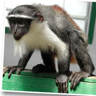

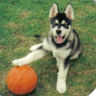

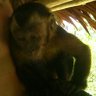

In [117]:
#text = translator("Черная кошка сидит")[0]['translation_text']
text = "Обезьяна играет с мячиком"
print(text)
text_search(text, photo_features, photo_ids, 3)